<a href="https://colab.research.google.com/github/arthur-pe/LtrRNN/blob/main/ltrRNN_example_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Example application of *low tensor rank recurrent neural networks***
---
Arthur Pellegrino, N Alex Cayco Gajic<sup>†</sup>, Angus Chadwick<sup>†</sup>

[Article link](https://proceedings.neurips.cc/paper_files/paper/2023/file/27030ad2ec1d8f2c3847a64e382c30ca-Paper-Conference.pdf)

<p align="center">
  <img width="600" src="https://raw.githubusercontent.com/arthur-pe/LtrRNN/main/img/ltrRNN_dark.png">
</p>

*Published at Neurips 2023*

# Data structure

There are 4 arrays which can be used by the ltrRNN code:
- (mandatory) **neural_data** (*time x trial x neuron*) : The neural data which can be either (latter recommended, see bellow):
  - Spikes, in which case neural_data.dtype must be integer, and the loss defaults to the negative poisson log-likelihood.
  - Estimate firing rates, in which case neural_data.dtype must be a float, and the loss defaults to MSE.
- (optional) **times** (*time*): Time within the experiment (e.g. in milliseconds). *Used for plotting only*.
- (optional) **condition** (*trial*): The task condition within the experiment. It must be an array of int (note that the condition color will be determined according to colormap(condition/(max(condition)+1))). *Used only for plotting unless condition-wise control*.
- (optional) **epoch** (*trial*): If you task can be split into epochs (e.g. baseline vs. perturbation in the main paper), then you can allow for discontinuities in the trial factor at the change of epoch (see ``discontinuous_convariance`` hyperparameter). *Used for plotting only if discontinuous_covariance=False and for fitting is discontinuous_covariance=True*.
- (optional) **trial_id** (*trial*): If trials were discarded as part of the pre-processing (e.g. animal failing the task), then you can choose to provide the original trial numbers here. The default is np.arange(neural_data.shape[1]), but this assumes an even distribution of learning. *Used for fitting the model*.

*Here ( ... x ...) indicates the shape of the numpy array.*

# Example dataset: *task-trained RNN learning a perturbed motor task.*

For the purpose of this example, we use data from an RNN trained on a perturbed reach task. Overall, the model can be described as follows:

An unconstrained RNN is trained on a center-out reach task using SGD. We start "recording" the RNN activity during the task only after it is trained.
- We record the RNN activity during 50 trials of the task.
- We introduce a perturbation in the task and retrain (using SGD) the RNN on this perturbed version of the task for 100.
- We remove the perturbation and retrain the RNN for 100 trials.

<p align="center">
  <img width="600" src="https://raw.githubusercontent.com/arthur-pe/LtrRNN/main/img/ttRNN.png">
</p>

Overall we have a RNN activity tensor of shape [time x 250 x neuron].

The full details of the task-trained RNN procedure is described in the main paper.

*If you are on Google Colab make sure to use GPU environment ``Runtime → Change runtime time type → GPU``.*

In [1]:
import numpy as np
import pickle
from scipy.ndimage import gaussian_filter1d

In [2]:
# Download the example data
!wget https://github.com/arthur-pe/LtrRNN/raw/main/example_data/task_trained_rnn_data.pkl

--2024-02-28 22:14:42--  https://github.com/arthur-pe/LtrRNN/raw/main/example_data/task_trained_rnn_data.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arthur-pe/LtrRNN/main/example_data/task_trained_rnn_data.pkl [following]
--2024-02-28 22:14:42--  https://raw.githubusercontent.com/arthur-pe/LtrRNN/main/example_data/task_trained_rnn_data.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48244938 (46M) [application/octet-stream]
Saving to: ‘task_trained_rnn_data.pkl’

task_trained_rnn_da 100%[===================>]  46.01M   195MB/s    in 0.2s    

2024-02-28 22:14:43 (195 MB/s) - ‘task_tr

In [3]:
# Implement your own import_data based on your need
def import_data(data_file):
    '''
    Loads the data of a task-tained RNN of motor perturbation learning in order to fit an ltrRNN to it.

    :param data_file: file containing the data

    :return: rnn_activity: (ndarray) time x trial x neuron. The activity of the RNN over learning.
    :return: condition: (ndarray) trial. The condition i.e. the target number (integer).
    :return: times: (ndarray) time. The time within a trial.
    :return: epoch: (ndarray) 3. The trial at which the epoch changes.
    :return: trial_id: (ndarray) trial. The true id of a trial, in case some trials are discarded.
    '''

    with open(data_file, 'rb') as f:
      data = pickle.load(f)

    # ===== Loading specific to your dataset =====
    neural_data = data['rnn_activity'][:,:, 0].transpose(1, 0, 2)
    condition = (data['condition'][:, 0]*8).astype(int)

    go_cue = data['additional_information']['preparatory_duration']+data['additional_information']['random_duration']/2
    times = data['time']-go_cue

    epoch = np.array(['BL']*50 + ['AD']*100 + ['WO']*100)
    trial_id = np.arange(len(condition))
    # ===============================================

    return neural_data, condition, times, epoch, trial_id

In [4]:
neural_data, condition, times, epoch, trial_id = import_data('./task_trained_rnn_data.pkl')

# For spike data we recommend smoothing into firing rates and z-scoring (optional)
if not np.issubdtype(neural_data.dtype, np.floating):
  neural_data = gaussian_filter1d(neural_data.astype(float), axis=0, sigma=4)
  neural_data = neural_data - neural_data.mean(axis=(0,1))
  neural_data = neural_data / (neural_data.std(axis=(0,1))+10**-6)

print(f'neural_data: {neural_data.shape}, times: {times.shape}, condition: {condition.shape}, epoch: {epoch.shape}, trial_id: {trial_id.shape}')

neural_data: (41, 250, 200), times: (41,), condition: (250,), epoch: (250,), trial_id: (250,)


# Hyperparameters

For most datasets the following three hyperparameters will be most useful to vary:
- ``rank`` : determines the dimension of the subspace in which the RNN dynamics are constrained.
- ``rnn_dim`` : determines the *complexity* of the dynamics within this subspace.
- ``l`` : determines the smoothness (in number of trials) of the trial factors, so that two trials are uncorrelated in approximately ``3*l`` trials. I.e. how fast learning is expected to occur.
- ``control_execution`` : determines whether the dynamics are autonomous after trial onset (e.g. go cue).

We recommend cross-validating these hyperparameters.

Check Supplementary Material A for thorough description of the hyperparameters.

In [5]:
hyperparameters = {
'seed' : 1,

# LtrRNN hyperparameters
'rnn_dim' : 200,
'rank' : 5,

'time_constant': 1.0,
'noise' : 0.0, # The RNN is driven by a Wiener process (can be useful to regularize dynamics)
'bias' : False,

'duration' : 2, # How long the RNN is simulated (e.g. real experiment seconds)

# Decoder -- the linear map from the RNN dimension to the data neuron dimension
'orthogonal_decoder' : True, # Orthonormal map (up to scaling)
'decoder_bias' : False, # Allows for translation

# Gaussian kernel
'sigma_observation' : 0.1, # Whether to allow non-smooth trial-to-trial variability
'l' : 15, # The length of the kernel, acts like a time (trial) constant
'sigma' : 0.1, # Magnitude of trial to trial variability
'discontinuous_covariance' : False, # Requires epoch parameter if True

# Controls (input) hyperparameters
# If you have a preparatory period this will allow having trial-to-trial variability in the initial (fit to data) state
# The preparatory period is determined as times < 0
'control_preparatory' : True,
'control_execution' : False,
'fit_preparatory' : False,
'condition_specific_init' : False,
'in_space_control' : True, # whether to constrain the controls to the span of a_i's

'control_dim' : 3, # Ignored if in_space_control
'control_dnn_dim' : [150,150], # Dimensions of the layers of the DNN parameterizing the neural ODE controls
'control_hidden_dim' : 150, # Dimensions of the neural ODE controls
'time_constant_control' : 2,
'trial_rank_control' : -1, #if -1 condition-wise

#training hyperparameters
'fraction_masked' : 0.2, # Masks some entries of the tensor to help optimization
'fraction_test' : 0.2, # Maximum fraction of entries taken by the test set (see fig. 4b)

'learning_rate' : 0.001,
'test_freq' : 50, # Frequency at which to update the plots
'regularization' : 0.01,
'regularization_function' : 'square', # 'square' or 'abs' ; the latter can make the activity sparser

# If std of the test loss over the past steps_std_convergence is less than min_std_convergence, break
'training_iterations' : 3000,
'min_std_convergence' : 0.001,
'steps_std_convergence' : 200,

'optimize' : True # Set to False if you just want to load a model
}

# Installing ltrRNN

In [ ]:
!pip install git+https://github.com/arthur-pe/LtrRNN

import ltrRNN

# Fitting

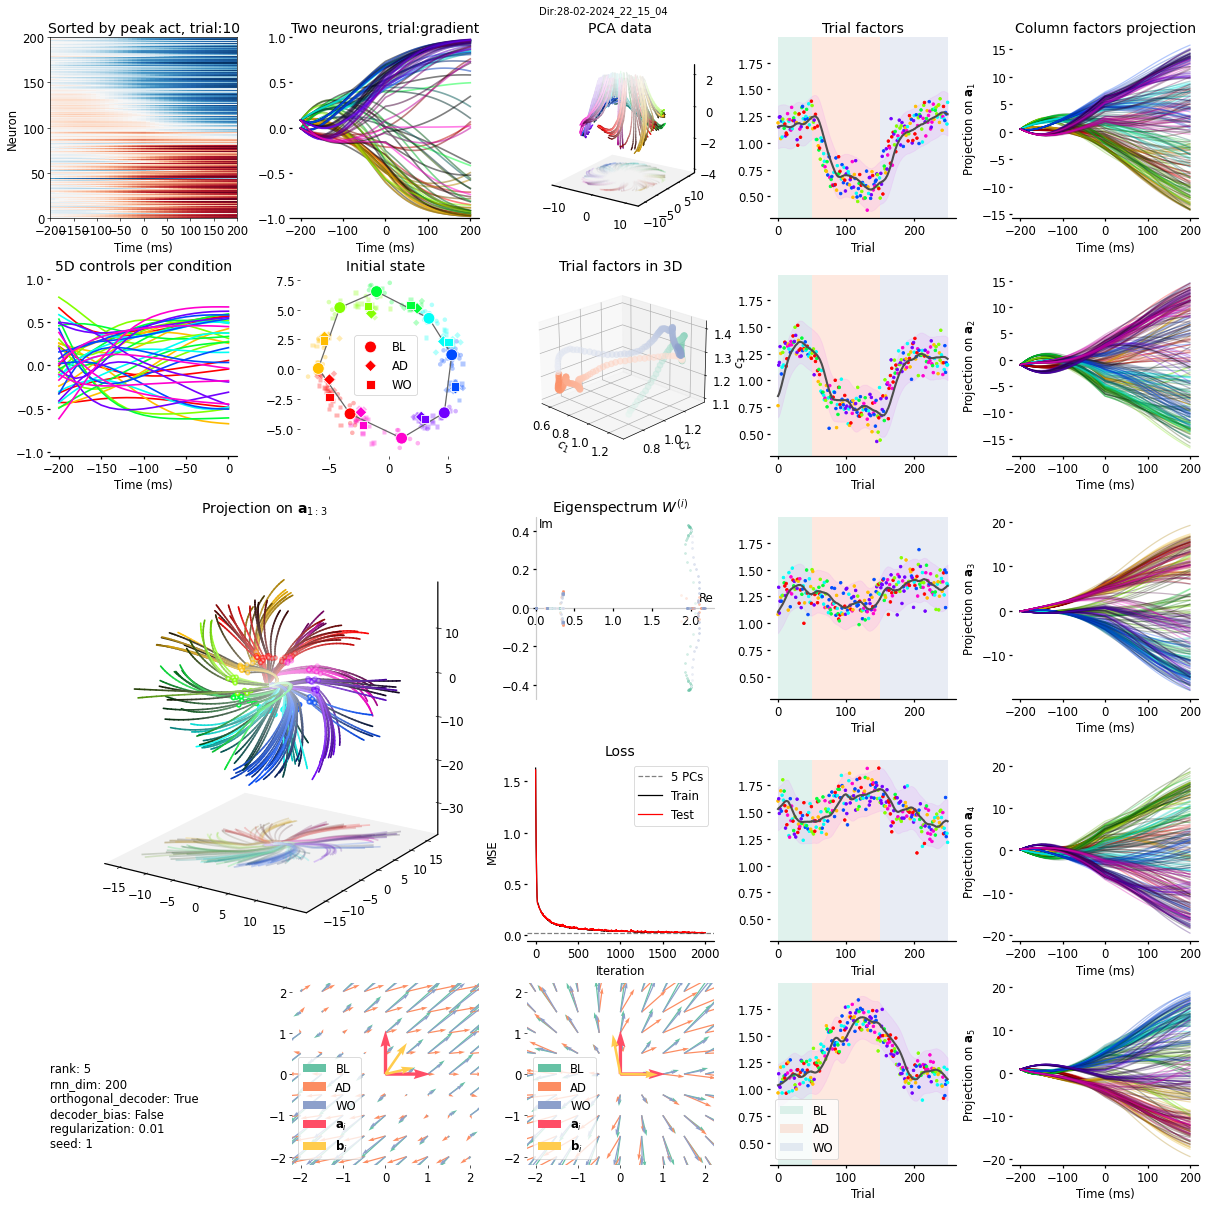

Iteration: 2000, L_total: 8.9676e-03, L_test:9.5102e-03, L_reg: 5.3445e-01, L_reg_control_prep:, 1.4673e-01, L_reg_control_exec: 0.0000e+00, L_reg_rnn: 3.8772e-01:  67%|██████▋   | 2000/3000 [52:01<26:00,  1.56s/ iteration]

0.0009624577488464111


In [8]:
ltrRNN.fit(hyperparameters, # See above
           neural_data, # (time x trial x neuron)
           condition, # (trial)
           times, # (time)
           epoch, # (trial)
           trial_id, # (trial)
           )

Note the output can take a few seconds to draw if you are on Google Colab. If you are on a local Jupyter notebook include ``%matplotlib notebook`` at the top of your notebook.

# Cross-validation mask

First, we define the entries to use for training and testing. If no mask is passed to the ``fit`` function, all entries are used for training.

<p align="center">
  <img width="150" src="https://github.com/arthur-pe/LtrRNN/blob/main/img/cross-validation-tensor.png?raw=true">
</p>

In [7]:
half_train_block, half_test_block = [5, 5, 1], [2, 2, 1]
mask_shape = neural_data.shape if hyperparameters['fit_preparatory'] else neural_data[times>=0].shape
train_mask, test_mask = ltrRNN.block_mask(mask_shape, half_train_block, half_test_block, hyperparameters['fraction_test'])

print(f'Fraction of entries used for training: {train_mask.float().mean().item()}, testing: {test_mask.float().mean().item()}, shape: {train_mask.shape}')

Fraction of entries used for training: 0.4347047507762909, testing: 0.17054380476474762, shape: torch.Size([21, 250, 200])


# Gridsearch

In order to determine the best hyperaparameters we can cross-validate models with various combination of them. The code currently supports crossvalidating two hyperparameters at a time across multiple seeds. For example, in order to crossvalidate models of `dimension=50, rank=1`, `dimension=200, rank=1`, `dimension=50, rank=2`, ... and repeat that over three initializations (seeds), you can use the following:

In [ ]:
ltrRNN.grid_search(hyperparameters, neural_data, condition, times, epoch, trial_id, train_mask, test_mask,
                   cv_hyperparameters={'rnn_dim': [50, 200], 'rank': [1, 5, 10]}, seeds=[1, 2, 3])

The output is saved in the ``. /cv /all`` directory, and all models and figures of the gridsearch are saved in individual directories within it. Since the above fits $2\times 3 \times 3=18$ models, it can take a few hours to run a gridsearch.

Pellegrino, A., Cayco Gajic, N. A., & Chadwick, A. (2024). Low Tensor Rank Learning of Neural Dynamics. *Advances in Neural Information Processing Systems*, 36.